<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook <br>with pre-trained embeddings and FAISS</b> </font><br>
    <font size="6"><b>Abt - Buy</b> </font>
   <hr>
</div>

In [7]:
!python --version

Python 3.9.1


In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
# d1 = pd.read_csv("./data/test/ccer/abt_100.csv", sep='|', engine='python', na_filter=False).astype(str)
# d2 = pd.read_csv("./data/test/ccer/buy_100.csv", sep='|', engine='python', na_filter=False).astype(str)
# gt = pd.read_csv("./data/test/ccer/gt_100.csv", sep='|', engine='python')

d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

attr1 = d1.columns[1:].to_list()
attr2 = d2.columns[1:].to_list()


data = Data(dataset_1=d1,
            attributes_1=attr1,
            id_column_name_1='id',
            dataset_2=d2,
            attributes_2=attr2,
            id_column_name_2='id',
            ground_truth=gt)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
d1

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158
...,...,...,...,...
1071,1071,Logitech Cordless Desktop Wave Keyboard And Mo...,Logitech Cordless Desktop Wave Keyboard And Mo...,79
1072,1072,Mitsubishi DLP Black TV Stand - MBS73V,Mitsubishi DLP Black TV Stand - MBS73V/ Matchi...,549
1073,1073,Logitech Digital Precision PC Gaming Headset -...,Logitech Digital Precision PC Gaming Headset -...,49
1074,1074,Logitech 2.1 Multimedia Silver Speaker System ...,Logitech 2.1 Multimedia Silver Speaker System ...,


In [25]:
data.dataset_1

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158
...,...,...,...,...
1071,1071,Logitech Cordless Desktop Wave Keyboard And Mo...,Logitech Cordless Desktop Wave Keyboard And Mo...,79
1072,1072,Mitsubishi DLP Black TV Stand - MBS73V,Mitsubishi DLP Black TV Stand - MBS73V/ Matchi...,549
1073,1073,Logitech Digital Precision PC Gaming Headset -...,Logitech Digital Precision PC Gaming Headset -...,49
1074,1074,Logitech 2.1 Multimedia Silver Speaker System ...,Logitech 2.1 Multimedia Silver Speaker System ...,


In [6]:
def _tokenize_entity(entity: str) -> str:
        return entity.strip().lower()#' '.join(list(filter(None, re.split('[\\W_]', entity.lower()))))


attributes_1=None

entities_d1 = data.dataset_1[attributes_1 if attributes_1 else data.attributes_1] \
                    .apply(" ".join, axis=1) \
                    .apply(_tokenize_entity) \
                    .values.tolist()

In [8]:
entities_d1[0]

'sony turntable - pslx350h sony turntable - pslx350h/ belt drive system/ 33-1/3 and 45 rpm speeds/ servo speed control/ supplied moving magnet phono cartridge/ bonded diamond stylus/ static balance tonearm/ pitch control'

In [11]:
td1 = d1[['id','name','description', 'price']]

entities_d1 = td1[attributes_1 if attributes_1 else data.attributes_1] \
                    .apply(" ".join, axis=1) \
                    .apply(_tokenize_entity) \
                    .values.tolist()

In [12]:
entities_d1[0]

'sony turntable - pslx350h sony turntable - pslx350h/ belt drive system/ 33-1/3 and 45 rpm speeds/ servo speed control/ supplied moving magnet phono cartridge/ bonded diamond stylus/ static balance tonearm/ pitch control'

In [4]:
gt.head(5)

,D1,D2
0,206,216
1,60,46
2,182,160
3,428,223
4,816,789


In [15]:
attr1 = d1.columns[1:].to_list()
attr2 = d2.columns[1:].to_list()

# attr1.remove('aggregate value')
# attr2.remove('aggregate value')

print(attr1)
print(attr2)

['name', 'description', 'price']
['name', 'description', 'price']


,name,description,price
0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158
...,...,...,...
1071,Logitech Cordless Desktop Wave Keyboard And Mo...,Logitech Cordless Desktop Wave Keyboard And Mo...,79
1072,Mitsubishi DLP Black TV Stand - MBS73V,Mitsubishi DLP Black TV Stand - MBS73V/ Matchi...,549
1073,Logitech Digital Precision PC Gaming Headset -...,Logitech Digital Precision PC Gaming Headset -...,49
1074,Logitech 2.1 Multimedia Silver Speaker System ...,Logitech 2.1 Multimedia Silver Speaker System ...,


In [19]:
d1.columns.values.tolist()

['id', 'name', 'description', 'price']

In [16]:
d1[attr1]

,name,description,price
0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158
...,...,...,...
1071,Logitech Cordless Desktop Wave Keyboard And Mo...,Logitech Cordless Desktop Wave Keyboard And Mo...,79
1072,Mitsubishi DLP Black TV Stand - MBS73V,Mitsubishi DLP Black TV Stand - MBS73V/ Matchi...,549
1073,Logitech Digital Precision PC Gaming Headset -...,Logitech Digital Precision PC Gaming Headset -...,49
1074,Logitech 2.1 Multimedia Silver Speaker System ...,Logitech 2.1 Multimedia Silver Speaker System ...,


# Block Building

## FAISS

faiss.IndexIVFFlat is an implementation of an inverted file index with coarse quantization. This index is used to efficiently search for nearest neighbors of a query vector in a large dataset of vectors. Here's a brief explanation of the parameters used in this index:

- `d`: The dimension of the input vectors. Each input vector should have d elements.
- `nlist`: The number of cells (or clusters) to divide the dataset into. This determines the number of inverted lists in the index, and hence the maximum number of vectors that can be stored in the index. Larger values of nlist will generally result in more accurate search results, but may also increase the memory requirements of the index and the time required to perform searches.
- `quantizer`: An instance of a quantizer object that is used to compress the vectors before they are added to the index. The quantizer object should implement a train method that learns the quantization function from a set of input vectors, and a compress method that compresses a vector into an integer code. FAISS provides several built-in quantizer objects, such as IndexFlatL2 and IndexScalarQuantizer.
- `metric`: The distance metric used to measure the similarity between vectors. The metric should be one of the strings defined in the faiss.METRIC_TYPES list, such as "l2" for Euclidean distance or "ip" for inner product.
- `nprobe`: The number of cells (or clusters) to search during a query. This parameter determines the tradeoff between accuracy and speed during searches. Larger values of nprobe will generally result in more accurate search results, but may also increase the time required to perform searches.



In [16]:
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

In [44]:
emb = EmbeddingsNNBlockBuilding(vectorizer='sminilm',
                                similarity_search='faiss')
blocks, g = emb.build_blocks(data, 
                          top_k=5,
                            similarity_distance='cosine',
                          load_embeddings_if_exist=False,
                          save_embeddings=False,
                          with_entity_matching=True)

Building blocks via Embeddings-NN Block Building [sminilm, faiss]


Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

['name', 'description', 'price']
['name', 'description', 'price']
Device selected:  cpu
Creating sentence embeddings...
NORMALIZED
NORMALIZED
NORMALIZED


In [45]:
# 1.
import torch

from sentence_transformers import SentenceTransformer
from scipy import spatial, stats

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('all-MiniLM-L12-v2', device=device)

e2 = 0
print(emb._entities_d2[e2])
encoded_2 = model.encode(emb._entities_d2[e2])

res = []
for e1 in range(0, len(emb._entities_d1)):
    encoded_1 = model.encode(emb._entities_d1[e1])
    sim_score = 1 - spatial.distance.cosine(encoded_1, encoded_2)
    res.append((e1, sim_score))

linksys etherfast ezxs88w ethernet switch - ezxs88w linksys etherfast 8-port 10/100 switch (new/workgroup)


In [46]:
# 2

top_k = 5
sorted_list = sorted(res, key=lambda x: x[1], reverse=True)
print("Brute-force: ", sorted_list[:5])
print("pyJedAI:     ",[(x,y) for x,y in zip(emb.neighbors[0][:top_k], emb.distances[0][:top_k])])

Brute-force:  [(1023, 0.7504152059555054), (1020, 0.6593941450119019), (1022, 0.6422648429870605), (134, 0.6380040049552917), (1021, 0.6196042895317078)]
pyJedAI:      [(1023, 0.7504153), (1020, 0.6593942), (1022, 0.64226484), (134, 0.63800395), (1021, 0.6196043)]


In [47]:
emb.evaluate(blocks, with_classification_report=True, with_stats=True)

***************************************************************************************************************************
                                         Μethod:  Embeddings-NN Block Building
***************************************************************************************************************************
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: sminilm
	Similarity-Search: faiss
	Top-K: 5
	Vector size: 384
Runtime: 156.5100 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.38% 
	Recall:        93.77%
	F1-score:      17.05%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1009
	False positives: 9751
	True negatives: 1147958
	False negatives: 67
	Total comparisons: 10760
──────────────────────────────────────────────

{'Precision %': 9.37732342007435,
 'Recall %': 93.77323420074349,
 'F1 %': 17.049678945589726,
 'True Positives': 1009,
 'False Positives': 9751,
 'True Negatives': 1147958,
 'False Negatives': 67}

In [7]:
emb.evaluate(blocks, with_classification_report=True, with_stats=True)

***************************************************************************************************************************
                                         Μethod:  Embeddings-NN Block Building
***************************************************************************************************************************
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: sminilm
	Similarity-Search: faiss
	Top-K: 5
	Vector size: 384
Runtime: 32.8045 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      4.90% 
	Recall:       100.00%
	F1-score:       9.34%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 49
	False positives: 951
	True negatives: 9049
	False negatives: 0
	Total comparisons: 1000
───────────────────────────────────────────────────────

{'Precision %': 4.9,
 'Recall %': 100.0,
 'F1 %': 9.34223069590086,
 'True Positives': 49,
 'False Positives': 951,
 'True Negatives': 9049,
 'False Negatives': 0}

In [7]:
from pyjedai.matching import EntityMatching

EM = EntityMatching(similarity_threshold=0.0)
EM.data = data
EM.evaluate(g)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Tokenizer: white_space_tokenizer
	Metric: dice
	Similarity Threshold: 0.0
Runtime: 0.0000 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.38% 
	Recall:        35.69%
	F1-score:       4.46%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 2.379182156133829,
 'Recall %': 35.687732342007436,
 'F1 %': 4.4609665427509295,
 'True Positives': 384,
 'False Positives': 15756,
 'True Negatives': 1141328,
 'False Negatives': 692}

# Entity Matching

In [8]:
from pyjedai.matching import EntityMatching

In [9]:
EM = EntityMatching(metric='cosine_vector_similarity',
                    similarity_threshold=0.0)

pairs_graph = EM.predict(blocks,
                         data,
                         tqdm_disable=True,
                         vectors_d1=emb.vectors_1,
                         vectors_d2=emb.vectors_2)

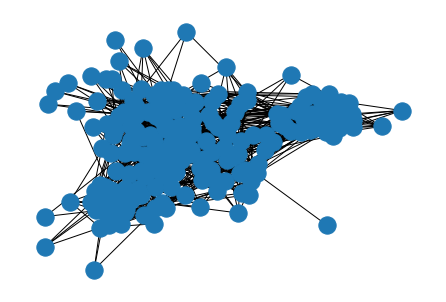

In [8]:
draw(pairs_graph)

In [10]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Tokenizer: white_space_tokenizer
	Metric: cosine_vector_similarity
	Similarity Threshold: 0.0
Runtime: 9.9167 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.38% 
	Recall:        35.69%
	F1-score:       4.46%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 2.379182156133829,
 'Recall %': 35.687732342007436,
 'F1 %': 4.4609665427509295,
 'True Positives': 384,
 'False Positives': 15756,
 'True Negatives': 1141328,
 'False Negatives': 692}

Distribution-% of predicted scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.775712515489467, 68.45724907063196, 28.767038413878566]


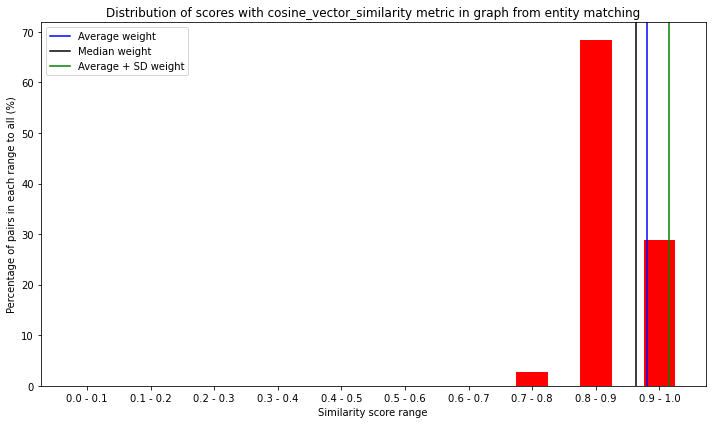

In [11]:
EM.plot_distribution_of_scores()

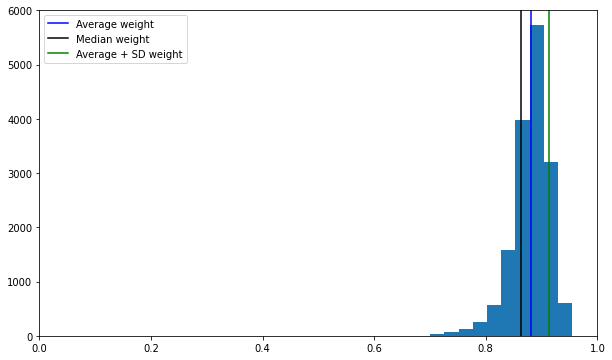

In [12]:
EM.plot_distribution_of_all_weights()

Distribution-% of predicted scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37174721189591076, 3.62453531598513, 55.111524163568774, 40.89219330855018]


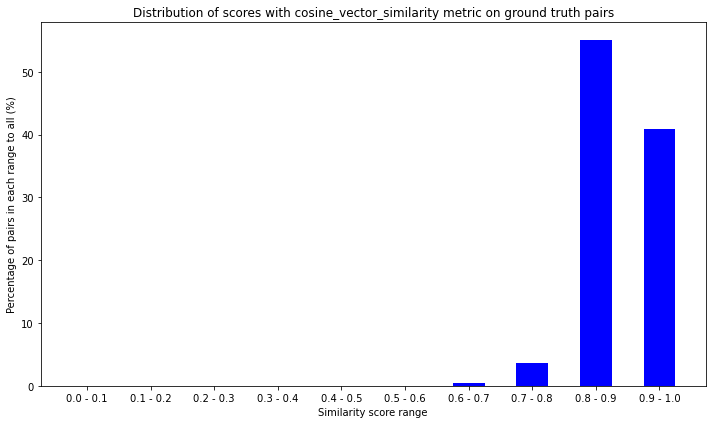

In [13]:
EM.plot_gt_distribution_of_scores()

In [14]:
EM.get_weights_avg()

0.8808228324078569

In [15]:
EM.get_weights_median()

0.86252517

In [16]:
EM.get_weights_standard_deviation()

0.03343073060295381

# Entity Clustering

In [20]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [27]:
ccc = UniqueMappingClustering()
clusters = ccc.process(g, data, similarity_threshold=0.7)

In [28]:
ccc.evaluate(clusters, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Unique Mapping Clustering
***************************************************************************************************************************
Method name: Unique Mapping Clustering
Parameters: 
Runtime: 0.0396 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     82.78% 
	Recall:        67.47%
	F1-score:      74.35%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 726
	False positives: 151
	True negatives: 1157275
	False negatives: 350
	Total comparisons: 877
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 82.78221208665907,
 'Recall %': 67.4721189591078,
 'F1 %': 74.34715821812597,
 'True Positives': 726,
 'False Positives': 151,
 'True Negatives': 1157275,
 'False Negatives': 350}